## Figure 7: 

Vertical profiles of spatially integrated (a) cloud radiative and microphysical heating rates averaged between days 5 to 8. Panel (b) demonstrates the associated PV tendencies. The dashed lines depict the profiles in the REF simulation.

-----------------------

@ Behrooz Keshtgar, KIT

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

import colorlegend

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


In [3]:
# Dictionary for loading simulations
simdict = {
         'LC1-channel-4000x9000km-2km-0002' : {'res':'2.5km', 'radiation':0, 'rh':0.8, 'mphy':1}, # No radiation 
         'LC1-channel-4000x9000km-2km-0003' : {'res':'2.5km', 'radiation':1, 'rh':0.8, 'mphy':1}, # Cloud radiation 
         }

## 2- Loading datasets

In [4]:
# load temperature tendencies datasets on model levels
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        #print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        # datasets
        fname = path+"icon-ddt_temp*.nc"                                                                     
        ds_var = (xr.open_mfdataset(fname, combine='by_coords',parallel=True))
        # adding cloud-radiative heating rates and total physic tendency
        ds_var['ddt_temp_radsw'] = ds_var['ddt_temp_radswnw'] - ds_var['ddt_temp_radswcs']
        ds_var['ddt_temp_radlw'] = ds_var['ddt_temp_radlwnw'] - ds_var['ddt_temp_radlwcs']
        # deriving total physics heating rates
        if sim == 'LC1-channel-4000x9000km-2km-0002':
            ds_var['ddt_temp_totphy'] = ds_var['ddt_temp_mphy'] + ds_var['ddt_temp_pconv'] + ds_var['ddt_temp_turb'] + ds_var['ddt_temp_diff'] + ds_var['ddt_temp_drag']
        else:
            ds_var['ddt_temp_totphy'] = ds_var['ddt_temp_radlw'] + ds_var['ddt_temp_radsw'] + ds_var['ddt_temp_mphy'] + ds_var['ddt_temp_pconv'] + ds_var['ddt_temp_turb'] + ds_var['ddt_temp_diff'] + ds_var['ddt_temp_drag']
        ds_list.append(ds_var)    
        del ds_var
    return ds_list
#----------------------------------
ds_list_ddt_temp = load_simulations()
#----------------------------------
def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        print('Working on loading data for', sim)
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/'
        # datasets
        fname = path+"pv_tendencies.nc"
        ds_var = xr.open_mfdataset(fname)
        ds_list.append(ds_var)
        
        del ds_var
    return ds_list
#----------------------------------
ds_list = load_simulations()
#----------------------------------

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003


## 3- Vertical profiles

In [5]:
# deriving Vertical profiles of heating rates and PV tendencies accumulated from day 5 to 8
def spin(var,time1,time2):
    dA = np.cos(np.deg2rad(45))
    dA = np.broadcast_to(dA.reshape((1, 1)), (len(var.lat), len(var.lon))).copy()
    dA /= dA.sum(axis=(0,1))
    # domain integral
    si = (var.sel(time=slice(time1,time2)).mean('time')*dA[None,:,:]).sum(axis=(1,2))
    return(si)

# heating rates
radlw_1 = spin(ds_list_ddt_temp[1].ddt_temp_radlw,20210106,20210109).compute()
radsw_1 = spin(ds_list_ddt_temp[1].ddt_temp_radsw,20210106,20210109).compute()
gscp_1  = spin(ds_list_ddt_temp[1].ddt_temp_gscp,20210106,20210109).compute()
gscp_0  = spin(ds_list_ddt_temp[0].ddt_temp_gscp,20210106,20210109).compute() # REF simulation

# dibatic pv tendencies
pvt_radlw_1 = spin(ds_list[1]['ddt_pv_z_radlw'],20210106,20210109).compute()
pvt_radsw_1 = spin(ds_list[1]['ddt_pv_z_radsw'],20210106,20210109).compute()
pvt_gscp_1  = spin(ds_list[1]['ddt_pv_z_gscp'],20210106,20210109).compute()
pvt_gscp_0  = spin(ds_list[0]['ddt_pv_z_gscp'],20210106,20210109).compute() # REF simulation

## 4- Plot

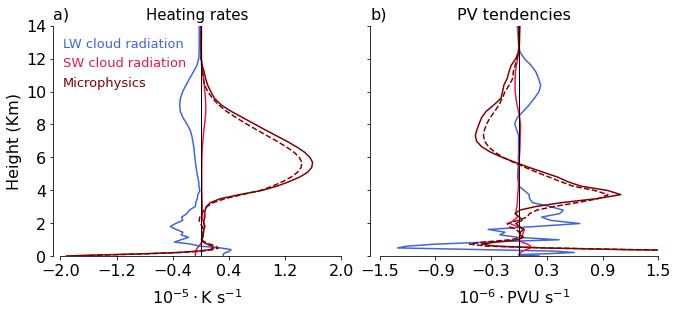

In [64]:
lev = ds_list[0].z_fl[0,:,50,50].values/1000 # hPa
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

i = 0

for ax in axes.flat:
    
    ax.tick_params(labelsize=16)       
    ax.spines['left'].set_bounds(0,14)
    ax.set_yticks(np.arange(0,16,2))
    ax.set_ylim([0,14])
       
    if i == 0:
        ax.plot(radlw_1*1e5,lev,'#4363d8',label='LW cloud radiation',linewidth=1.5)
        ax.plot(radsw_1*1e5,lev,'#e6194B',label='SW cloud radiation',linewidth=1.5)
        ax.plot(gscp_1*1e5,lev,'#800000',label='Microphysics',linewidth=1.5)
        ax.plot(gscp_0*1e5,lev,'#800000',linewidth=1.5,linestyle='dashed')
        lg=colorlegend.color_legend(ax,loc=2,fsize=13)
        ax.tick_params(left=True,right=False)
        ax.set_title('Heating rates', fontsize=15)
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.set_ylabel('Height (Km)', fontsize=16)
        ax.set_xlabel('$10^{-5} \cdot $K s$^{-1}$', fontsize=16,labelpad=10)
        ax.ticklabel_format(style='sci',scilimits=(0,0),axis='x')
        ax.spines['bottom'].set_bounds(-2,2)
        ax.set_xticks(np.linspace(-2,2,6))
        ax.set_xlim([-2.1,2])
        ax.text(0.0, 1.03, 'a)', transform=ax.transAxes, 
            size=16 )
        
    if i == 1:
        ax.plot(pvt_radlw_1*1e6*1e6,lev,'#4363d8',linewidth=1.5)
        ax.plot(pvt_radsw_1*1e6*1e6,lev,'#e6194B',linewidth=1.5)
        ax.plot(pvt_gscp_1*1e6*1e6,lev,'#800000',linewidth=1.5)
        ax.plot(pvt_gscp_0*1e6*1e6,lev,'#800000',linewidth=1.5,linestyle='dashed')
        ax.tick_params(left=True,right=False)
        ax.set_title('PV tendencies', fontsize=16)
        ax.set_xlabel('$10^{-6} \cdot $PVU s$^{-1}$', fontsize=16,labelpad=10)
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.ticklabel_format(style='sci',scilimits=(0,0),axis='x')
        ax.spines['bottom'].set_bounds(-1.5,1.5)
        ax.set_xticks(np.linspace(-1.5,1.5,6))
        ax.set_xlim([-1.6,1.5])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, 'b)', transform=ax.transAxes, 
            size=16 )
        
    i = i + 1 
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.1)   

plt.savefig('figure7.pdf', bbox_inches = 'tight')
#plt.savefig('figure7.png', bbox_inches = 'tight',dpi=100)